# ベイズ法によるパラメータ推測

$x=(x_1, x_2, ..., x_n)^T$を同時確率密度関数$f(x|θ)$が定義するパラメトリックモデルから生成されたデータとする。  
$θ \in Θ$をモデルを定めるパラメータ、$Θ$をパラメータ空間($θ$の取りうる値の全体)とする。ここでは$θ$の**ベイズ推測**の問題を考える。  
ベイズ法では、$θ$を単一の値と考えるのではなく、$θ$のとりうる値に関する情報を確率分布で表現する。  
したがって、$f(x|θ)$は条件付き確率密度関数と解釈する。  
データ$x$を観測する以前にもっている$θ$に関する事前情報を確率分布で表したものを**事前分布**という。  
ここでは、$θ$は連続型確率密度分布に従うものとし、事前分布の確率密度関数を$π(θ)$で表す。  
パラメトリックモデル$f(x|θ)$と事前分布$π(θ)$の組を**ベイズモデル**という。  
データ$x$を観測したとき、ベイズの定理によって
$$
π(θ|x) = \frac{f(x|θ)π(θ)}{\int_{Θ} f(x|θ)π(θ)dθ}
$$
を得る。  
$π(θ|x)$が定義する条件付き分布は、データ$x$の情報を得た後の$θ$に関する情報と解釈することができ、**事後分布**とよばれる。  
上式は$π(θ)$から$π(θ|x)$への更新則と解釈することができる。ベイズ法では事後分布$π(θ|x)$に基づいて$θ$に関する推測を行う。  
上式の右辺の分母
$$
f(x)=\int_{Θ} f(x|θ)π(θ)dθ
$$
は事後分布の確率密度関数を規格化定数で、**周辺尤度**とよばれる。  
周辺尤度$f(x)$は$θ$によらないことから、事後分布$π(θ|x)$は$π(θ|x) \propto f(x|θ)π(θ)$と表すことができる。

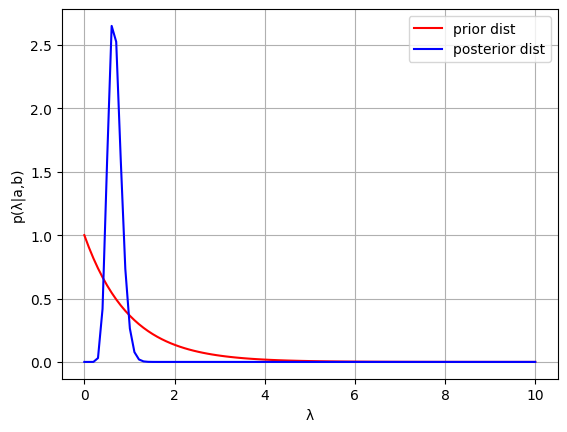

In [2]:
# ベイズ法を実行
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

x = np.linspace(0, 10,100)

# 事前分布のパラメータ
a = 1.0
b = 1.0

# 観測データ
data = np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 
                 0, 0, 0, 2, 1, 1, 1, 2, 3, 1,
                 2, 0, 0, 0, 2, 1, 0, 2, 1, 0])

# データから事後分布のパラメータを算出
def possison_posterior(data, a, b):
    N = data.shape[0]
    hat_a = np.sum(data) + a
    hat_b = N + b
    return hat_a, hat_b

hat_a, hat_b = possison_posterior(data, 1.0, 1.0)

plt.plot(x, gamma.pdf(x,a,scale=1./b), label="prior dist", color="red")
plt.plot(x, gamma.pdf(x,hat_a,scale=1./hat_b),label="posterior dist", color="blue")

plt.xlabel("λ")
plt.ylabel('p(λ|a,b)')
plt.legend()
plt.grid()
plt.show()

# ベイズ法による点推定

ベイズ法では、事後分布$π(θ|x)$が$θ$の推測結果にほかならないが、実用上は点推定や区間推定が必要になる場面も多い。  
点推定量としては、**ベイズ推定量**と**MAP推定量**がよく用いられる。  
ベイズ推定量：$θ$の事後分布に対する期待値
$$
\hat{θ_B} = \int_{θ \in Θ}θ \cdot π(θ|x)dθ
$$
を$θ$のベイズ推定量という。  
MAP推定量：$θ$の事後分布のモード
$$
\hat{θ}_{MAP} = \arg \max_{θ \in Θ} π(θ|x)
$$
をMAP(最大事後確率)推定量という。  
実用的なベイズモデルでは、周辺尤度を解析的に計算することが困難であることが多い。  
MAP推定量は周辺尤度を計算しなくてもf(x|θ)*π(θ)だけから求められることが利点である。

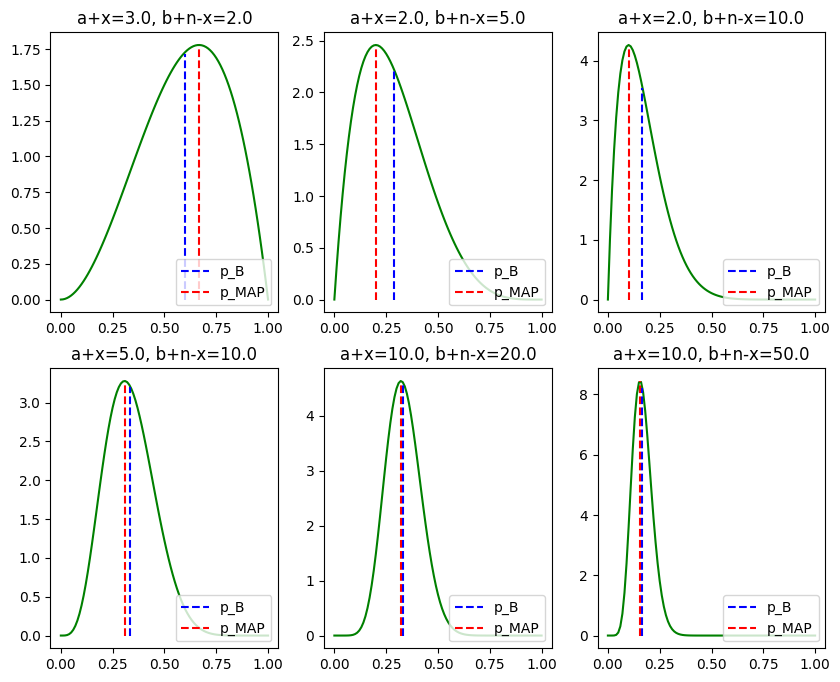

In [4]:
# ベイズ推定量とMAP推定量を計算
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# ベータ関数のパラメータ
a = np.array([3., 2., 2., 5., 10., 10.])
b = np.array([2., 5., 10., 10., 20., 50.])

x = np.arange(0., 1.01, 0.01)
y = np.zeros([x.shape[0], a.shape[0]])

plt.figure(figsize=(10,8))
for i in range(6):
    plt.subplot(2,3,i+1)

    # ベータ関数を描画
    y[:,i] = stats.beta.pdf(x, a[i], b[i])
    plt.plot(x,y[:,i],color="green")

    # ベイズ推定量を描画
    plt.plot(np.repeat(a[i]/(a[i]+b[i]),20), np.linspace(0,stats.beta.pdf(a[i]/(a[i]+b[i]),a[i],b[i])-0.01,20),"b--", label="p_B")

    # MAP推定量を描画
    plt.plot(np.repeat((a[i]-1.)/(a[i]+b[i]-2.),20), np.linspace(0,stats.beta.pdf((a[i]-1.)/(a[i]+b[i]-2.),a[i],b[i])-0.01,20), "r--", label="p_MAP")
    
    plt.title(f"a+x={a[i]}, b+n-x={b[i]}")
    plt.legend(loc=4)

plt.show()

観測サンプルが多くなるにつれて推定結果が収束していくことも確認できる。

# ベイズ法による区間推定

ベイズ法において区間推定をする場合は**信用区間**が通常用いられる。  
$θ$の$100(1-α)%$信用区間$I=(l,u)$は、事後分布を用いて
$$
\int_{l}^{u}π(θ|x)dθ = 1-\alpha
$$
を満たす区間として定義される。  
$l,u$の取り方はいくらでも存在するが、よく用いられるのは
$$
I_{HPD} = \{θ|π(θ|x) \geq c(\alpha)\} \quad s.t \quad
\int_{I_{HPD}} π(θ|x)dθ = 1-\alpha
$$
を満たすような区間$I_{HPD}$である。これを**最大事後密度区間**という。

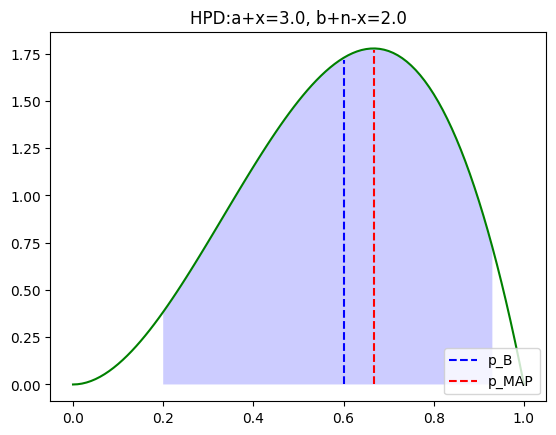

In [5]:
# 上記の事後分布(ベータ関数)より95%信用区間を描画
a = 3.
b = 2.
x = np.arange(0., 1.01, 0.01)
y = stats.beta.pdf(x, a, b)
l_point = stats.beta.ppf(0.025, a, b)
u_point = stats.beta.ppf(0.975, a, b)


plt.plot(x, y, color="green")
plt.fill_between(x, y, where=((l_point<=x)&(x<=u_point)), facecolor='blue', alpha=0.2)

# ベイズ推定量を描画
plt.plot(np.repeat(a/(a+b),20), np.linspace(0,stats.beta.pdf(a/(a+b),a,b)-0.01,20),"b--", label="p_B")

# MAP推定量を描画
plt.plot(np.repeat((a-1.)/(a+b-2.),20), np.linspace(0,stats.beta.pdf((a-1.)/(a+b-2.),a,b)-0.01,20), "r--", label="p_MAP")

plt.title(f"HPD:a+x={a}, b+n-x={b}")
plt.legend(loc=4)
plt.show()

# 事前分布

ベイズ法において事前分布をどのように選ぶかは重要な問題である。  
例えば、二項分布のモデルにおけるベイズ法による推測で、事前分布にベータ分布を仮定したモデルは**ベータ二項モデル**という。  
ベータ二項モデルでは事後分布もまたベータ分布になる。  
ベータ二項分布モデルでは、この更新がベータ分布のパラメータ更新になるので簡便である。  
この例のように、事前分布の取り方によっては、事前分布と事後分布が同じ確率分布になることがある。  
このような事前分布を**共役事前分布**という。  
ベータ二項モデルのほかにも、ポアソン分布のモデルに対して、ガンマ分布は共役事前分布である。  
このモデルを**ガンマ・ポアソンモデル**という。

代表的なものをまとめると以下の通り

| 共役事前分布 | 尤度関数(分布) | 事後分布 |
| :----: | :----: | :----: |
|  ベータ分布 | ベルヌーイ分布 | ベータ分布 |
|  ベータ分布 | 二項分布 | ベータ分布 |
|  正規分布 | 正規分布(分散既知) | 正規分布 |
|  ガンマ分布 | ポアソン分布 | ガンマ分布 |

なお、ベータ二項モデルにおける事後分布は、試行回数$n$、事象が発生する回数を$x$とした場合、
$$
Be(\alpha+x, \quad \beta+n-x)
$$
となり、ベイズ推定量は$\alpha/(\alpha+\beta)$、MAP推定量は$(\alpha-1)/(\alpha+\beta-2)$となる。

また、ガンマ・ポアソンモデルにおける事後分布は、観測した事象を$x_i$、その事象の数を$n$とした場合、
$$
Ga(\alpha+\sum_{i=1}^{n} x_i, \quad 1/(\beta+n))
$$
となり、ベイズ推定量は$\alpha/\beta$、MAP推定量は$(\alpha-1)/\beta$となる。

正規分布における事後分布は、事前分布を$N_0(\mu_0, {\sigma_0}^2)$とし、サンプルを$N(\mu, \sigma^2)$から大きさ$n$抽出し、標本平均を$\bar{x}$とした場合、
$$
N(\frac{{\sigma_0}^2 n \bar{x} + \sigma^2 \mu_0}{{\sigma_0}^2 n + \sigma^2}, \quad \frac{{\sigma_0}^2 \sigma^2}{{\sigma_0}^2 + \sigma^2})
$$
となる。

# ベイズ予測

観測されたデータ$x=(x_1,x_2, ..., x_n)^T$を用いて、将来観測されるデータ$x_{n+1}$の分布を予測することを考える。  
$x$,$θ$を所与としたときの$x_{n+1}$の条件付き確率密度関数を$f(x_{n+1}|θ)$とする。  
多くの場合、観測データは$θ$が所与の下では独立と仮定されるので、$f(x_{n+1}|θ)=f(x_n|θ)$となる。  
ベイズ法では、
$$
f(x_{n+1}|x) = \int_{θ \in Θ}f(x_{n+1}|x,θ)π(θ|x)dθ
$$
を用いて、$x_{n+1}$の予測を行う。これを**ベイズ予測分布**という。

# MHアルゴリズム

共役事前分布を用いれば事後分布は標準的な確率分布になり、事後分布に基づく考察も容易である。  
しかし、共役事前分布以外の事前分布を用いた場合、パラメトリックモデルや事前分布が標準的な確率分布であったとしても、事後分布は一般に標準的な確率分布にはならない。  
また、多くの場合、周辺尤度関数の計算が困難で、確率密度関数の明示的な計算も容易ではない。  
このような場合、事後分布に従う乱数をサンプリングして、モンテカルロシミュレーションによって事後分布に関する考察を行うことが考えられる。  
事後分布を不変分布にもつマルコフ連鎖に従う乱数の発生は比較的容易である。  
このような方法は**マルコフ連鎖モンテカルロ法**(**MCMC法**)とよばれる。  
MCMC法の中で、最も基本的な方法は**メトロポリス・ヘイスティングス(MH)アルゴリズム**である。  
サンプリングを行いたい確率分布を**目標分布**とよぶ。ベイズ法の場合、事後分布とよぶ。  
MHアルゴリズムでは、**提案分布**という確率分布を用いて目標分布からのサンプリングを行う。  
MHアルゴリズムでは、提案分布からサンプルの候補を発生させ、目標分布に依存した**採択確率**に基づいて採択/棄却を決める。

mean:5.135912916841872
standard deviation:0.42388274575892587


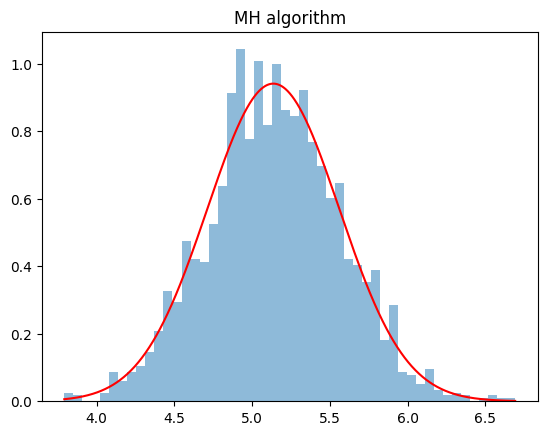

In [6]:
# MHアルゴリズムを実践
from scipy.stats import norm

# 適当なデータを生成
mu_X = 5.0
sigma_X = 3.0
N = 50
X = norm.rvs(mu_X, sigma_X, size=N)

# 事前分布を設定(平均：μ0=1.0、標準偏差：σ0=10のガウス分布)
mu_0 = 1.0
sigma_0 = 10

# 提案分布関数のパラメータ
sigma_q = 0.5

# 事前分布を返す関数
def prior(mu):
    return norm.pdf(mu, mu_0, sigma_0)

# 提案分布関数：目標分布からのサンプリングを行う
def q(mu, mu_cond):
    return norm.pdf(mu, mu_cond, sigma_q)

# 提案分布から候補点をランダムに取得する関数
def sampling_q(mu):
    return norm.rvs(mu, sigma_q)

# 周辺尤度を計算する関数
def f(mu, X):
    # 尤度x事前分布
    return np.prod(norm.pdf(X, mu, sigma_X)) * prior(mu)

# MH法によるサンプリング関数
def MH_method(w, X, q, sampling_q, f):    
    # 1. 提案分布から候補点を取得
    w_new = sampling_q(w)
    # 2. 候補点の採択確率計算
    a = (f(w_new, X)*q(w, w_new))/(f(w, X)*q(w_new, w))
    # 3. 採択判定
    is_accept = np.random.uniform() < min(1, a)
    return w_new, is_accept

# MH法でサンプルリストを取得する関数
def sampling_MH(X, q, sampling_q, f, sample_num, warmup, w_init):    
    w = w_init
    samples = []
    while(len(samples) < sample_num + warmup):
        w_new, is_accept = MH_method(w, X, q, sampling_q, f)
        # 4. 採択された場合はwを遷移
        if is_accept:
            w = w_new
            samples.append(w)
    samples = samples[warmup:]
    return samples


sample_num = 2000
warmup = 500 # 初期値の影響を受けるので、いくつかのサンプルは無視する
mu_init = 0.0
mu_samples = sampling_MH(X, q, sampling_q, f, sample_num, warmup, mu_init)


# muの事後分布
X_mean = np.average(X)
eq_mu_N = (sigma_X**2*mu_0 + N*sigma_0**2*X_mean)/(sigma_X**2 + N*sigma_0**2)
eq_sigma_N = np.sqrt((sigma_0**2*sigma_X**2)/(sigma_X**2 + N*sigma_0**2))
print(f'mean:{eq_mu_N}')
print(f'standard deviation:{eq_sigma_N}')

# muの事後分布を描画
plt.hist(mu_samples, bins=50, density=True, alpha=0.5)
plt_arr = np.linspace(min(mu_samples), max(mu_samples), 1000)
plt.plot(plt_arr, norm.pdf(plt_arr, eq_mu_N, eq_sigma_N), c='r')
plt.title("MH algorithm")
plt.show()

# ギブス・サンプリング

事後分布からのサンプリングとして、MHアルゴリズムと並んでよく用いられるものに、**ギブス・サンプリング**がある。  
ここでも目標分布は事後分布$π(θ|x)$である。$θ=(θ_1,...,θ_k)^T$とし、$θ_{-i}=(θ_1,...,θ_{i-1},θ_{i+1},...,θ_K)^T$と定義する。  
ギブス・サンプリングでは、$x,θ_{-i}$を所与としたときの$θ_i$の条件付き分布
$$
π(θ_i|θ_{-i},x), \quad
i=1,2,..,K
$$
からの乱数生成が容易であると仮定する。  
上記の条件付き分布を**完全条件付き分布**という。  
事後分布からの乱数生成が困難でも、完全条件付き分布からの乱数生成であれば容易ということはしばしばある。  
また、ギブス・サンプリングの場合、提案分布を設定する必要がないことから、実装は容易である。

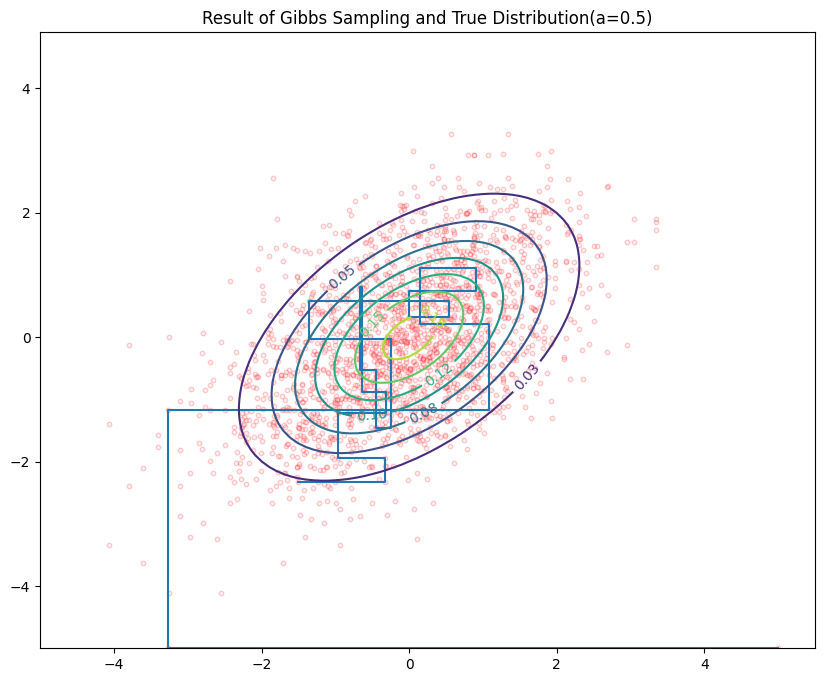

In [7]:
# 多変量ガウス分布(2次元)を条件付き分布としてギブス・サンプリングを実行
import numpy as np
import matplotlib.pyplot as plt
import math

# 多変量ガウス分布データを計算
def gaussian(x, y, mean, co_var):
    output = np.array([])
    x = x - mean[0]
    y = y - mean[1]
    for i in range(x.shape[0]):
        z = 1/(2*math.pi)*math.sqrt(np.linalg.det(co_var))*np.exp(-0.5 * np.dot(np.dot(np.array([x[i, :],y[i, :]]).T, np.linalg.inv(co_var)), np.array([x[i, :],y[i, :]])))
        z = np.diag(z)
        output = np.append(output, z)
    output = output.reshape(x.shape[0], x.shape[0])
    return output

# 初期データ
x = np.array([5., -5.])

# 完全条件付き分布のパラメータ
a = 0.5

step = 1000
sample = np.array(x)

# ギブス・サンプリングを実行
for i in range (step):
    x[0] = np.random.normal(a*x[1], 1) # 与えられたx1でp(x0∣x1)に基づいてx0を発生させる
    sample = np.append(sample, (x))
    x[1] = np.random.normal(a*x[0], 1) # 与えられたx0でp(x1∣x0)に基づいてx1を発生させる
    sample = np.append(sample, (x))

sample = sample.reshape((2*step+1, x.shape[0]))

# 多変量ガウス分布を描画
t = np.arange(-5, 5, 0.1)
x,y =np.meshgrid(t, t)
z = gaussian(x, y, np.array([0, 0]), 1/(1-a**2) * np.array([[1, a],[a, 1]]))

plt.figure(figsize=(10,8))
plt.title(f'Result of Gibbs Sampling and True Distribution(a={a})')
plt.scatter(sample[:, 0], sample[:, 1], s=10, c='pink', alpha=0.2, edgecolor='red')

# ギブス・サンプルのトラッキングを描画
plt.plot(sample[0:30, 0], sample[0:30, 1])

c = plt.contour(x,y,z)
c.clabel(fmt='%1.2f', fontsize=10)
plt.show()